In [1]:
import mdtraj as md
from msmbuilder.example_datasets import FsPeptide
from msmbuilder.dataset import dataset
import tempfile
import os
from msmbuilder.featurizer import DihedralFeaturizer
from msmbuilder.preprocessing import RobustScaler
from msmbuilder.decomposition import tICA
%matplotlib inline
import msmexplorer as msme
import numpy as np
from msmbuilder.cluster import MiniBatchKMeans
from matplotlib import pyplot as plt
from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump, map_drawn_samples
from msmbuilder.tpt import net_fluxes, paths
from msmbuilder.lumping import PCCAPlus

/Users/callumdickson/anaconda2/envs/msmbuilder/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/callumdickson/anaconda2/envs/msmbuilder/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/callumdickson/anaconda2/envs/msmbuilder/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version.

In [2]:
# helpful tutorials:
# http://msmbuilder.org/mdentropy/0.3.0/examples/mutual-information.html
# http://msmbuilder.org/3.8.0/examples/Fs-Peptide-in-RAM.html

In [3]:
# Fs_peptide
fs_peptide = FsPeptide(verbose=False)
fs_peptide.cache()

In [4]:
# Work in a temporary directory
os.chdir(tempfile.mkdtemp())

In [5]:
# Load traj and top files as MSMBuilder 'dataset' object
trajectories = dataset(fs_peptide.data_dir + "/*.xtc",
              topology=fs_peptide.data_dir + '/fs-peptide.pdb',
              stride=10)

print("{} trajectories".format(len(trajectories)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.5
print("with length {} ns".format(set(len(x)*to_ns for x in trajectories)))

/Users/callumdickson/anaconda2/envs/msmbuilder/lib/python3.5/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


28 trajectories
with length {500.0} ns


In [6]:
# Featurize data using dihedral angles
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = trajectories.fit_transform_with(featurizer, 'diheds/', fmt='dir-npy')

print(trajectories[0].xyz.shape)
print(diheds[0].shape)

(1000, 264, 3)
(1000, 84)


In [7]:
# Scale the data to remove bias
scaler = RobustScaler()
scaled_diheds = diheds.fit_transform_with(scaler, 'scaled_diheds/', fmt='dir-npy')

print(diheds[0].shape)
print(scaled_diheds[0].shape)

(1000, 84)
(1000, 84)


In [8]:
# Run TICA
tica_model = tICA(lag_time=2, n_components=4)

# fit and transform can be done in seperate steps:
tica_model = scaled_diheds.fit_with(tica_model)
tica_trajs = scaled_diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

(1000, 84)
(1000, 4)


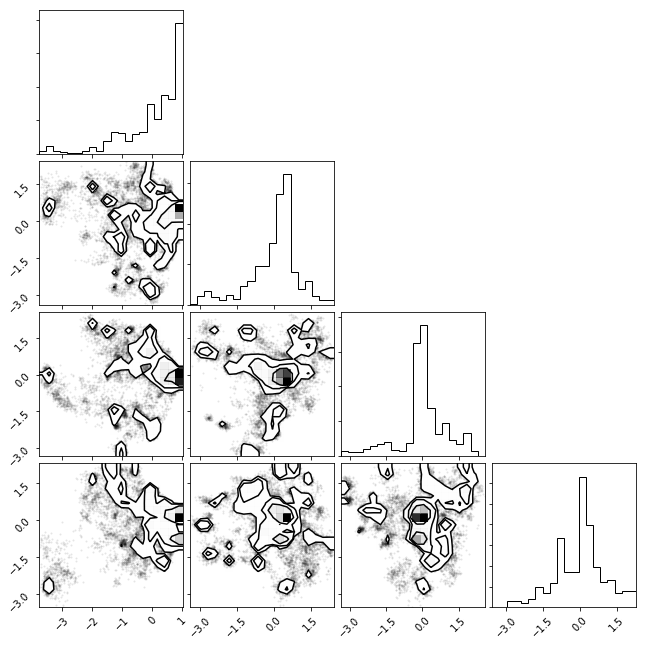

In [9]:
# View histograms along tica coordinates
txx = np.concatenate(tica_trajs)
_ = msme.plot_histogram(txx)

In [10]:
# Run clustering
clusterer = MiniBatchKMeans(n_clusters=100, random_state=42)
clustered_trajs = tica_trajs.fit_transform_with(
    clusterer, 'kmeans/', fmt='dir-npy'
)

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(1000, 4)
(1000,)


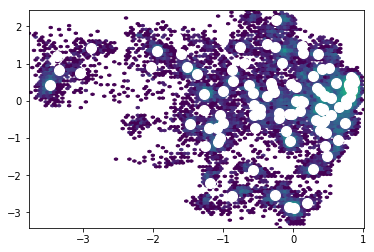

In [11]:
# View cluster distribution
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [12]:
# Fit MSM
msm = MarkovStateModel(lag_time=2, n_timescales=20)
msm.fit(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.50. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=2, n_timescales=20,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

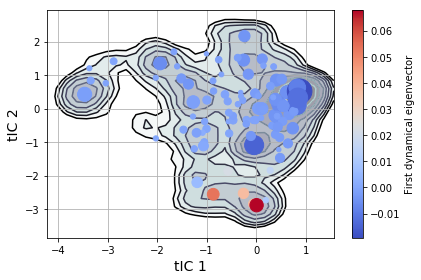

In [13]:
# View MSM assignments and distribution
assignments = clusterer.partial_transform(txx)
assignments = msm.partial_transform(assignments)

msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm",
            zorder=3) 
plt.colorbar(label='First dynamical eigenvector')
plt.tight_layout()

In [14]:
# transform clustered_trajs to map back to msm assignmets
msm_assignments=msm.transform(clustered_trajs)

In [15]:
# Randomly sample MSM states and save to single traj file

pairs = msm.draw_samples(msm_assignments, n_samples=5)
samples = map_drawn_samples(pairs, trajectories)

coord_new = []
for state in range(0,len(samples)):
    for traj_id in samples[state]:
        coord_new.append(traj_id.xyz)
    
adaptive = md.Trajectory(np.concatenate(coord_new, axis=0), trajectories[0].topology)
adaptive.superpose(adaptive[0])
adaptive.save('adaptive.nc')

In [16]:
# Save the folding pathway to traj file
sources, sinks = [msm.populations_.argmin()], [msm.populations_.argmax()]
net_flux = net_fluxes(sources, sinks, msm)
paths, _ = paths(sources, sinks, net_flux, num_paths=0)

coord_new = []
for state in paths[0]:
    for traj_id in samples[state]:
        coord_new.append(traj_id.xyz)
        
pathway = md.Trajectory(np.concatenate(coord_new, axis=0), trajectories[0].topology)
pathway.superpose(pathway[0])
pathway.save('pathway.nc')

In [17]:
msm.timescales_

array([ 1828.39712674,  1249.05156066,   572.64450379,   311.83576047,
         304.83499194,   298.62208741,   229.75694066,   204.46270416,
         139.46187681,   132.14353997,   118.04011919,   110.4724879 ,
         105.30093279,    79.05111008,    69.94166198,    66.06612995,
          61.18444057,    53.25150699,    48.54605458,    46.21971236])

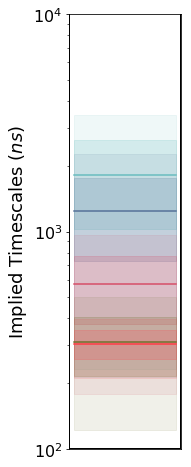

In [18]:
# Plot MSM timescales
msme.plot_timescales(msm, n_timescales=5,
                     ylabel='Implied Timescales ($ns$)')

In [19]:
# Lump MSM into Macrostates using PCCA+
n_macrostates=4
pcca = PCCAPlus.from_msm(msm, n_macrostates)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -3.988809
         Iterations: 8
         Function evaluations: 87


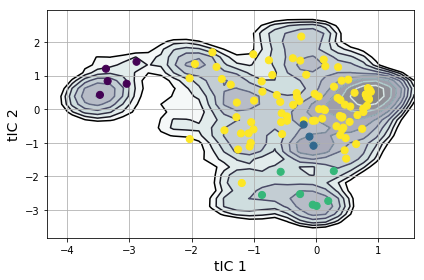

In [20]:
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
            zorder=3
           )
plt.tight_layout()

In [21]:
# Randomly sample macrostates and save to different traj files

samples=pcca.draw_samples(macro_trajs,n_samples=50)

for macrostate in range(0,n_macrostates):
    coord_new = []
    for traj_id, frame in samples[macrostate]:
        coord_new.append(trajectories[traj_id][frame].xyz)
    
    macro = md.Trajectory(np.concatenate(coord_new, axis=0), trajectories[0].topology)
    macro.superpose(macro[0])
    macro.save('macrostate_%d.nc' % (macrostate))

In [23]:
os.getcwd()

'/private/var/folders/32/5rmqyxgs66b1r9lhqr981gyc0000gn/T/tmpeyyuoak1'